## Look at number of neurons that participate into ripple events

stats are in recruit_frac_r_stats.ipynb

In [1]:
import pandas as pd
import sys
import pickle
sys.path.append("D:/ryanh/github/ripple_analyses")
from functions import *
from matplotlib import pyplot as plt
import numpy as np

from tqdm import tqdm

import itertools

import seaborn as sns



Bad key "text.kerning_factor" on line 4 in
D:\ryanh\Anaconda3\envs\ripple_analysis\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test_patch.mplstyle.
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.1.2/matplotlibrc.template
or from the matplotlib source distribution


In [2]:
project_path = 'F:/Projects/PAE_PlaceCell/'
analysis_path = project_path+'analysis/'
data_path = project_path+'ProcessedData/'          
save_path = analysis_path+"ripple_modulation/"
df_swr = pd.read_csv(analysis_path+'swr_data/post_processed/swr_df.csv')
df_cell_class = pd.read_csv(analysis_path+'cell_recruitment/processed/pyr_int_df.csv')

spikes_path = 'F:/Projects/PAE_PlaceCell/analysis/spikes'

In [36]:
def add_group_affiliation(df):
    control=('RH13','RH14','LS21','LS23','LE2821','LE2823','LEM3116','LEM3120','LEM3216')
    pae=('RH11','RH16','LS17','LS19','LE2813','LEM3124','LEM3206','LEM3246')

    df['group'] = np.ones_like(df.session)

    regstr = '|'.join(control)
    idx = df['session'].str.upper().str.contains(regstr)    
    df.loc[idx,'group'] = 'control'

    regstr = '|'.join(pae)
    idx = df['session'].str.upper().str.contains(regstr)    
    df.loc[idx,'group'] = 'pae'
    return df

def get_recruted(spikes,df_swr,session):
    # loop through each ripple and each cell to see if the ripple recruited each cell
    recruited = np.zeros([len(df_swr[df_swr.session == session]),spikes.shape[0]])
    for i,event in enumerate(df_swr[df_swr.session == session].itertuples()):
        for j,s in enumerate(spikes):
            recruited[i,j] = any((s >= event.start_time) & (s <= event.end_time))

    # fraction of all recorded neurons participating in each ripple        
    recruit_frac = recruited.sum(axis=1) / spikes.shape[0]     
    
    participation_prob = recruited.sum(axis=0) / recruited.shape[0]    

    return recruit_frac, participation_prob



### running this will not split pyr and int

Look for the code below

In [4]:
recruit_frac = []
area = []
session_ = []
n_ripples = []
n_cells = []
for session in tqdm(df_swr.session.unique()):

    spikes = np.load(
        os.path.join(spikes_path,session+'.npy'),
        allow_pickle=True
    )

    # maybe multiple areas in a single recording session
    for area_ in df_cell_class[df_cell_class.session == session].area.unique():
        # pull out cells for current session
        cur_spikes = spikes[df_cell_class[df_cell_class.session == session].area==area_]
        # restrict cells to those with >= 100 spikes
        n_spikes = [len(s) for s in cur_spikes]
        cur_spikes = cur_spikes[np.array(n_spikes) >= 100]
        # calculate the fraction of active units per ripple
        recruit_frac.append(get_recruted(cur_spikes,df_swr,session))
        # add number of ripples
        n_ripples.append(np.repeat(len(df_swr[df_swr.session == session]), len(df_swr[df_swr.session == session])))      
        # add number of cells
        n_cells.append(np.full(len(df_swr[df_swr.session == session]),cur_spikes.shape[0]))
        # add area ID
        area.append([area_]*len(df_swr[df_swr.session == session]))
        # add session ID
        session_.append([session]*len(df_swr[df_swr.session == session]))


100%|████████████████████████████████████████████████████████████████████████████████| 189/189 [02:55<00:00,  1.08it/s]


In [5]:
df = pd.DataFrame()

df['session'] = list(itertools.chain(*session_))
rat = [s.split('_')[0] for s in df.session]
df['rat']=rat
df = add_group_affiliation(df)
df['area'] = list(itertools.chain(*area))
df['recruit_frac'] = list(itertools.chain(*recruit_frac))
df['n_ripples'] = list(itertools.chain(*n_ripples))
df['n_cells'] = list(itertools.chain(*n_cells))

display(df)
df.to_csv(r'F:\Projects\PAE_PlaceCell\analysis\ripple_modulation\post_processed\recruit_frac_df.csv')

,session,rat,group,area,recruit_frac,n_ripples,n_cells
0,LEM3116_S20180715121821,LEM3116,control,ca1,0.160000,11,25
1,LEM3116_S20180715121821,LEM3116,control,ca1,0.320000,11,25
2,LEM3116_S20180715121821,LEM3116,control,ca1,0.320000,11,25
3,LEM3116_S20180715121821,LEM3116,control,ca1,0.240000,11,25
4,LEM3116_S20180715121821,LEM3116,control,ca1,0.280000,11,25
...,...,...,...,...,...,...,...
20702,RH16_S20161126145021,RH16,pae,ca1,0.555556,1,18
20703,RH16_S20161126150318,RH16,pae,ca1,0.409091,3,22
20704,RH16_S20161126150318,RH16,pae,ca1,0.772727,3,22
20705,RH16_S20161126150318,RH16,pae,ca1,0.454545,3,22


# same analysis as above but for pyr and int seperately

In [19]:
recruit_frac = []
area = []
session_ = []
n_ripples = []
n_cells = []
cell_type = []
for session in tqdm(df_swr.session.unique()):

    spikes = np.load(
        os.path.join(spikes_path,session+'.npy'),
        allow_pickle=True
    )
    
    curr_df_cell_class = df_cell_class[df_cell_class.session == session]

    # maybe multiple areas in a single recording session
    for area_ in curr_df_cell_class.area.unique():
        # loop through each cell class
        for cell_type_ in curr_df_cell_class[(curr_df_cell_class.area==area_)].cell_type.unique():
            
            # pull out cells for current session
            cur_spikes = spikes[(curr_df_cell_class.area == area_) &
                                (curr_df_cell_class.cell_type == cell_type_)]
            # restrict cells to those with >= 100 spikes
            n_spikes = [len(s) for s in cur_spikes]
            cur_spikes = cur_spikes[np.array(n_spikes) >= 100]
            # calculate the fraction of active units per ripple and active ripple per unit
            recruit_frac_,participation_prob_ = get_recruted(cur_spikes,df_swr,session)
            recruit_frac.append(recruit_frac_)
            # add number of ripples
            n_ripples.append(np.repeat(len(df_swr[df_swr.session == session]), len(df_swr[df_swr.session == session])))      
            # add number of cells
            n_cells.append(np.full(len(df_swr[df_swr.session == session]),cur_spikes.shape[0]))
            # add cell type
            cell_type.append(np.full(len(df_swr[df_swr.session == session]),cell_type_))
            # add area ID
            area.append([area_]*len(df_swr[df_swr.session == session]))
            # add session ID
            session_.append([session]*len(df_swr[df_swr.session == session]))

100%|████████████████████████████████████████████████████████████████████████████████| 189/189 [02:54<00:00,  1.08it/s]


In [20]:
df = pd.DataFrame()

df['session'] = list(itertools.chain(*session_))
rat = [s.split('_')[0] for s in df.session]
df['rat']=rat
df = add_group_affiliation(df)
df['area'] = list(itertools.chain(*area))
df['recruit_frac'] = list(itertools.chain(*recruit_frac))
df['n_ripples'] = list(itertools.chain(*n_ripples))
df['n_cells'] = list(itertools.chain(*n_cells))
df['cell_type'] = list(itertools.chain(*cell_type))

display(df)
df.to_csv(r'F:\Projects\PAE_PlaceCell\analysis\ripple_modulation\post_processed\recruit_frac_df_v2.csv')

,session,rat,group,area,recruit_frac,n_ripples,n_cells,cell_type
0,LEM3116_S20180715121821,LEM3116,control,ca1,0.222222,11,18,pyr
1,LEM3116_S20180715121821,LEM3116,control,ca1,0.333333,11,18,pyr
2,LEM3116_S20180715121821,LEM3116,control,ca1,0.333333,11,18,pyr
3,LEM3116_S20180715121821,LEM3116,control,ca1,0.222222,11,18,pyr
4,LEM3116_S20180715121821,LEM3116,control,ca1,0.277778,11,18,pyr
...,...,...,...,...,...,...,...,...
39126,RH16_S20161126150318,RH16,pae,ca1,0.200000,3,10,pyr
39127,RH16_S20161126150318,RH16,pae,ca1,0.700000,3,10,pyr
39128,RH16_S20161126150318,RH16,pae,ca1,0.300000,3,10,pyr
39129,RH16_S20161207130000,RH16,pae,ca1,0.421053,1,19,int


In [37]:
participation_prob = []
area = []
session_ = []
n_ripples = []
n_cells = []
cell_type = []
n_spikes = []
for session in tqdm(df_swr.session.unique()):

    spikes = np.load(
        os.path.join(spikes_path,session+'.npy'),
        allow_pickle=True
    )
    
    curr_df_cell_class = df_cell_class[df_cell_class.session == session]

    # maybe multiple areas in a single recording session
    for area_ in curr_df_cell_class.area.unique():
        # loop through each cell class
        for cell_type_ in curr_df_cell_class[(curr_df_cell_class.area==area_)].cell_type.unique():
            
            # pull out cells for current session
            cur_spikes = spikes[(curr_df_cell_class.area == area_) &
                                (curr_df_cell_class.cell_type == cell_type_)]
            # restrict cells to those with >= 100 spikes
            n_spikes.append([len(s) for s in cur_spikes])
#             cur_spikes = cur_spikes[np.array(n_spikes) >= 100]
            # calculate the fraction of active units per ripple and active ripple per unit
            recruit_frac_,participation_prob_ = get_recruted(cur_spikes,df_swr,session)
            participation_prob.append(participation_prob_)
            # add number of ripples
            n_ripples.append(np.full(cur_spikes.shape[0], len(df_swr[df_swr.session == session])))      
            # add number of cells
            n_cells.append(np.full(cur_spikes.shape[0],cur_spikes.shape[0]))
            # add cell type
            cell_type.append(np.full(cur_spikes.shape[0],cell_type_))
            # add area ID
            area.append([area_]*cur_spikes.shape[0])
            # add session ID
            session_.append([session]*cur_spikes.shape[0])
                        


100%|████████████████████████████████████████████████████████████████████████████████| 189/189 [02:47<00:00,  1.13it/s]


In [45]:
df_part_prob = pd.DataFrame()

df_part_prob['session'] = list(itertools.chain(*session_))
rat = [s.split('_')[0] for s in df_part_prob.session]
df_part_prob['rat']=rat
df_part_prob = add_group_affiliation(df_part_prob)
df_part_prob['area'] = list(itertools.chain(*area))
df_part_prob['participation_prob'] = list(itertools.chain(*participation_prob))
df_part_prob['n_ripples'] = list(itertools.chain(*n_ripples))
df_part_prob['n_cells'] = list(itertools.chain(*n_cells))
df_part_prob['n_spikes'] = list(itertools.chain(*n_spikes))
df_part_prob['cell_type'] = list(itertools.chain(*cell_type))

display(df_part_prob)
df_part_prob.to_csv(r'F:\Projects\PAE_PlaceCell\analysis\ripple_modulation\post_processed\recruit_frac_df_part_prob.csv')

,session,rat,group,area,participation_prob,n_ripples,n_cells,n_spikes,cell_type
0,LEM3116_S20180715121821,LEM3116,control,ca1,0.818182,11,18,7340,pyr
1,LEM3116_S20180715121821,LEM3116,control,ca1,0.000000,11,18,1139,pyr
2,LEM3116_S20180715121821,LEM3116,control,ca1,0.909091,11,18,7490,pyr
3,LEM3116_S20180715121821,LEM3116,control,ca1,0.090909,11,18,1803,pyr
4,LEM3116_S20180715121821,LEM3116,control,ca1,0.000000,11,18,8589,pyr
...,...,...,...,...,...,...,...,...,...
8508,RH16_S20161207130000,RH16,pae,ca1,1.000000,1,10,5669,pyr
8509,RH16_S20161207130000,RH16,pae,ca1,0.000000,1,10,1119,pyr
8510,RH16_S20161207130000,RH16,pae,ca1,0.000000,1,10,1252,pyr
8511,RH16_S20161207130000,RH16,pae,ca1,0.000000,1,10,2433,pyr


# comparison plots

In [39]:
tex_fonts = {
#     # Use LaTeX to write all text
#     "text.usetex": True,
    "font.family": "serif",
    # Use 10pt font in plots, to match 10pt font in document
    "axes.labelsize": 10,
    "font.size": 10,
    # Make the legend/label fonts a little smaller
    "legend.fontsize": 8,
    "xtick.labelsize": 8,
    "ytick.labelsize": 8,
    "svg.fonttype": 'none'
}
plt.style.use('seaborn-paper')
plt.rcParams.update(tex_fonts)

# plt.rcParams['svg.fonttype'] = 'none'


%config InlineBackend.figure_format = 'retina'
fig_save_path = 'D:/ryanh/GoogleDrive/school_work/UNM/Lab/Projects/pae_ripple_paper/inkscape_figs/ripple_recuitment/'

In [41]:
group_colors = {"controlca1": '#222629ff',
                "controlca3": '#103876ff',
                'paeca1': '#ff5240ff',
                'paeca3': '#ebad46ff'} 
def ecdf(x):
    xs = np.sort(x)
    ys = np.linspace(0,1,len(xs))
    return xs, ys


def plot_ecdf(var,df,area,ax,group_colors):
    for rat in pd.unique(df.rat):
        y = df[(df.rat == rat) & (df.area == area)]
        if y.empty == False:
            xs, ys = ecdf(y[var])
            ax.plot(xs,ys,color=group_colors[y.group.iloc[0]+y.area.iloc[0]],linewidth=.5)

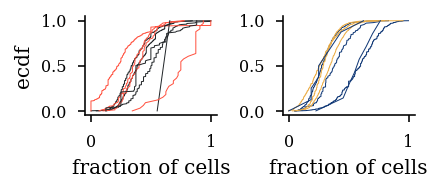

In [8]:
df2 = df


fig, axs = plt.subplots(1,2, figsize=set_size('thesis', fraction=.5, subplots=(1, 2)), edgecolor='k')
fig.subplots_adjust(hspace = 1.2, wspace=0.5)
axs = axs.ravel()

ax_num = [0,1]
plot_ecdf('recruit_frac',df2,'ca1',axs[ax_num[0]],group_colors)
axs[ax_num[0]].set_xlabel('fraction of cells')
axs[ax_num[0]].set_ylabel('ecdf')

plot_ecdf('recruit_frac',df2,'ca3',axs[ax_num[1]],group_colors)
axs[ax_num[1]].set_xlabel('fraction of cells')

for i in range(2):
    right_side = axs[i].spines["right"]
    right_side.set_visible(False)
    top_side = axs[i].spines["top"]
    top_side.set_visible(False)
    
plt.savefig(os.path.join(fig_save_path,'recruit_frac.svg'),dpi=300,bbox_inches='tight')    

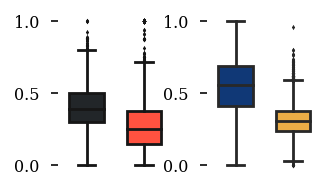

In [9]:
import seaborn as sns
fig, axs = plt.subplots(1,2, figsize=set_size('thesis', fraction=.4, subplots=(1, 1)), edgecolor='k')
fig.subplots_adjust(hspace = 0, wspace=.3)
axs = axs.ravel()

sns.set_palette(sns.color_palette([group_colors['controlca1'],group_colors['paeca1']]))
g=sns.boxplot(x="group", y="recruit_frac", data=df2[(df2.area=='ca1')],
            width=.6,ax=axs[0],saturation=1,fliersize=.5)
axs[0].axes.get_xaxis().set_ticks([])
g.set(xlabel=None)
g.set(ylabel=None)


sns.set_palette(sns.color_palette([group_colors['controlca3'],group_colors['paeca3']]))
g=sns.boxplot(x="group", y="recruit_frac", data=df2[(df2.area=='ca3')],
            width=.6,ax=axs[1],saturation=1,fliersize=.5)
axs[1].axes.get_xaxis().set_ticks([])
g.set(xlabel=None)
g.set(ylabel=None)

axs[0].set_ylim(min(axs[0].get_ylim()[0],axs[1].get_ylim()[0]),max(axs[0].get_ylim()[1],axs[1].get_ylim()[1]))
axs[1].set_ylim(min(axs[0].get_ylim()[0],axs[1].get_ylim()[0]),max(axs[0].get_ylim()[1],axs[1].get_ylim()[1]))
 
sns.despine(trim=True, left=True, bottom=True)
plt.savefig(os.path.join(fig_save_path,'recruit_frac_box.svg'),dpi=300,bbox_inches='tight')

In [21]:
df_cell_class = pd.read_csv(r'F:\Projects\PAE_PlaceCell\analysis\ripple_modulation\post_processed\pyr_int_df.csv')


In [72]:
print(df2[(df2.cell_type=='pyr') & (df2.area=='ca1') & (df2.group=='control')].rat.unique())
df2[(df2.cell_type=='pyr') & (df2.area=='ca1') & (df2.group=='control') & (df2.rat=='LEM3116')]

['LEM3116' 'LEM3120' 'LEM3216' 'LS23']


,session,rat,group,area,participation_prob,n_ripples,n_cells,n_spikes,cell_type
75,LEM3116_S20180717110938,LEM3116,control,ca1,0.367580,438,84,3426,pyr
76,LEM3116_S20180717110938,LEM3116,control,ca1,0.200913,438,84,299,pyr
77,LEM3116_S20180717110938,LEM3116,control,ca1,0.296804,438,84,6061,pyr
78,LEM3116_S20180717110938,LEM3116,control,ca1,0.006849,438,84,469,pyr
79,LEM3116_S20180717110938,LEM3116,control,ca1,0.125571,438,84,2114,pyr
...,...,...,...,...,...,...,...,...,...
256,LEM3116_S20180718184628,LEM3116,control,ca1,0.971698,106,20,59586,pyr
257,LEM3116_S20180718184628,LEM3116,control,ca1,0.122642,106,20,4889,pyr
258,LEM3116_S20180718184628,LEM3116,control,ca1,0.849057,106,20,79957,pyr
259,LEM3116_S20180718184628,LEM3116,control,ca1,0.047170,106,20,1891,pyr


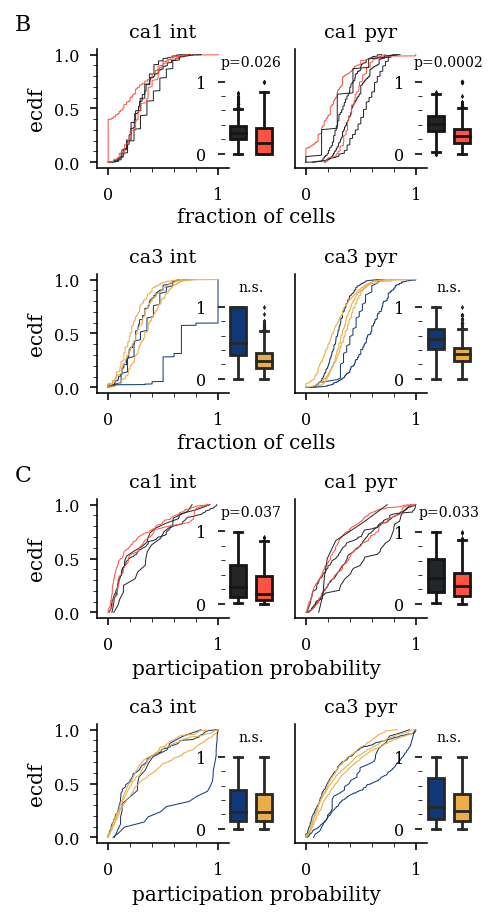

In [132]:
from matplotlib.ticker import AutoMinorLocator

df2 = df[(df.n_cells > 1) & (df.n_ripples >= 50)]

fig, axs = plt.subplots(4,2, figsize=set_size('thesis', fraction=.5, subplots=(4, 1)), edgecolor='k')
fig.subplots_adjust(hspace = .9, wspace=0.5)
axs = axs.ravel()

ax_num = [0,1]
plot_ecdf('recruit_frac',df2[df2.cell_type=='int'],'ca1',axs[ax_num[0]],group_colors)
axs[ax_num[0]].set_ylabel('ecdf')

plot_ecdf('recruit_frac',df2[df2.cell_type=='pyr'],'ca1',axs[ax_num[1]],group_colors)

ax_num = [2,3]
plot_ecdf('recruit_frac',df2[df2.cell_type=='int'],'ca3',axs[ax_num[0]],group_colors)
axs[ax_num[0]].set_ylabel('ecdf')
plot_ecdf('recruit_frac',df2[df2.cell_type=='pyr'],'ca3',axs[ax_num[1]],group_colors)


df2 = df_part_prob[((df_part_prob.n_ripples >= 50) &
   (df_part_prob.n_spikes >= 100))]
ax_num = [4,5]
plot_ecdf('participation_prob',df2[df2.cell_type == "int"],'ca1',axs[ax_num[0]],group_colors)
axs[ax_num[0]].set_ylabel('ecdf')
plot_ecdf('participation_prob',df2[df2.cell_type == "pyr"],'ca1',axs[ax_num[1]],group_colors)


ax_num = [6,7]
plot_ecdf('participation_prob',df2[df2.cell_type == "int"],'ca3',axs[ax_num[0]],group_colors)
axs[ax_num[0]].set_ylabel('ecdf')
plot_ecdf('participation_prob',df2[df2.cell_type == "pyr"],'ca3',axs[ax_num[1]],group_colors)


axs[0].set_title('ca1 int')
axs[1].set_title('ca1 pyr')
axs[2].set_title('ca3 int')
axs[3].set_title('ca3 pyr')
axs[4].set_title('ca1 int')
axs[5].set_title('ca1 pyr')
axs[6].set_title('ca3 int')
axs[7].set_title('ca3 pyr')


fig.text(0.5, 0.715, 'fraction of cells', ha='center')
fig.text(0.5, 0.5, 'fraction of cells', ha='center')
fig.text(0.5, 0.285, 'participation probability', ha='center')
fig.text(0.5, 0.07, 'participation probability', ha='center')

# for i, label in zip(np.arange(0,7,2),('B', 'C', 'D', 'E')):
#     axs[i].text(-0.5, 1.3, label, transform=axs[i].transAxes,
#     fontsize=11, fontweight='normal', va='top', ha='right')

axs[0].text(-0.5, 1.3, 'B', transform=axs[0].transAxes,
            fontsize=11, fontweight='normal', va='top', ha='right')
axs[4].text(-0.5, 1.3, 'C', transform=axs[4].transAxes,
            fontsize=11, fontweight='normal', va='top', ha='right')

axs[1].axes.get_yaxis().set_ticks([])
axs[3].axes.get_yaxis().set_ticks([])
axs[5].axes.get_yaxis().set_ticks([])
axs[7].axes.get_yaxis().set_ticks([])

for i in range(8):
    right_side = axs[i].spines["right"]
    right_side.set_visible(False)
    top_side = axs[i].spines["top"]
    top_side.set_visible(False)
    axs[i].xaxis.set_minor_locator(AutoMinorLocator())
    axs[i].yaxis.set_minor_locator(AutoMinorLocator())
    axs[i].set_xlim(-0.1,1.1)

# plt.tight_layout()

def plot_box(df,var,ax,group_colors,area,cell_type,title=''):
    '''
    Function to overlay box plots to the right of my custom ecdf plots
    '''
    pos1 = ax.get_position()
    pos2 = [pos1.x0 + 0.3, pos1.y0+.01,  pos1.width / 2.5, pos1.height / 1.5] 
    ax3 = fig.add_axes(pos2)
    sns.set_palette(sns.color_palette([group_colors['control'+area],group_colors['pae'+area]]))
    g=sns.boxplot(x="group", y=var, data=df[(df.area==area) & (df.cell_type==cell_type)],
                width=.6,ax=ax3,saturation=1,fliersize=.5)
    ax3.axes.get_xaxis().set_ticks([])
    g.set(xlabel=None)
    g.set(ylabel=None)
    ax3.yaxis.set_minor_locator(AutoMinorLocator())
    ax3.spines["right"].set_visible(False)
    ax3.spines["left"].set_visible(False)
    ax3.spines["top"].set_visible(False)
    ax3.spines["bottom"].set_visible(False)
    ax3.set_title(title,fontsize=7)
    
df2 = df[(df.n_cells > 1) & (df.n_ripples >= 50)]
    
plot_box(df2,"recruit_frac",axs[0],group_colors,'ca1','int',title='p=0.026')
plot_box(df2,"recruit_frac",axs[1],group_colors,'ca1','pyr',title='p=0.0002')   

plot_box(df2,"recruit_frac",axs[2],group_colors,'ca3','int',title='n.s.')
plot_box(df2,"recruit_frac",axs[3],group_colors,'ca3','pyr',title='n.s.')   

df2 = df_part_prob[((df_part_prob.n_ripples >= 50) &
   (df_part_prob.n_spikes >= 100))]

plot_box(df2,"participation_prob",axs[4],group_colors,'ca1','int',title='p=0.037')
plot_box(df2,"participation_prob",axs[5],group_colors,'ca1','pyr',title='p=0.033')

plot_box(df2,"participation_prob",axs[6],group_colors,'ca3','int',title='n.s.')
plot_box(df2,"participation_prob",axs[7],group_colors,'ca3','pyr',title='n.s.')



plt.savefig(os.path.join(fig_save_path,'recruit_frac_and_part_prob.svg'),dpi=300,bbox_inches='tight')    

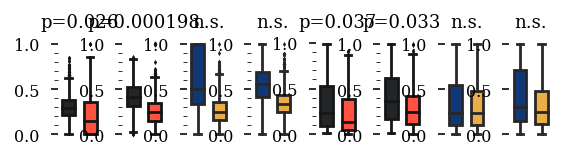

In [78]:

fig, axs = plt.subplots(1,8, figsize=set_size('thesis', fraction=.75, subplots=(2, 6)), edgecolor='k')
fig.subplots_adjust(hspace = 0.25, wspace=.5)
axs = axs.ravel()

df2 = df[(df.n_cells > 1) & (df.n_ripples >= 50)]

sns.set_palette(sns.color_palette([group_colors['controlca1'],group_colors['paeca1']]))
g=sns.boxplot(x="group", y="recruit_frac", data=df2[(df2.area=='ca1') & (df2.cell_type=='int')],
            width=.6,ax=axs[0],saturation=1,fliersize=.5)
axs[0].axes.get_xaxis().set_ticks([])
g.set(xlabel=None)
g.set(ylabel=None)

sns.set_palette(sns.color_palette([group_colors['controlca1'],group_colors['paeca1']]))
g=sns.boxplot(x="group", y="recruit_frac", data=df2[(df2.area=='ca1') & (df2.cell_type=='pyr')],
            width=.6,ax=axs[1],saturation=1,fliersize=.5)
axs[1].axes.get_xaxis().set_ticks([])
g.set(xlabel=None)
g.set(ylabel=None)

sns.set_palette(sns.color_palette([group_colors['controlca3'],group_colors['paeca3']]))
g=sns.boxplot(x="group", y="recruit_frac", data=df2[(df2.area=='ca3') & (df2.cell_type=='int')],
            width=.6,ax=axs[2],saturation=1,fliersize=.5)
axs[2].axes.get_xaxis().set_ticks([])
g.set(xlabel=None)
g.set(ylabel=None)

sns.set_palette(sns.color_palette([group_colors['controlca3'],group_colors['paeca3']]))
g=sns.boxplot(x="group", y="recruit_frac", data=df2[(df2.area=='ca3') & (df2.cell_type=='pyr')],
            width=.6,ax=axs[3],saturation=1,fliersize=.5)
axs[3].axes.get_xaxis().set_ticks([])
g.set(xlabel=None)
g.set(ylabel=None)



df2 = df_part_prob[((df_part_prob.n_ripples >= 50) &
   (df_part_prob.n_spikes >= 100))]

sns.set_palette(sns.color_palette([group_colors['controlca1'],group_colors['paeca1']]))
g=sns.boxplot(x="group", y="participation_prob", data=df2[(df2.area=='ca1') & (df2.cell_type=='int')],
            width=.6,ax=axs[4],saturation=1,fliersize=.5)
axs[4].axes.get_xaxis().set_ticks([])
g.set(xlabel=None)
g.set(ylabel=None)

sns.set_palette(sns.color_palette([group_colors['controlca1'],group_colors['paeca1']]))
g=sns.boxplot(x="group", y="participation_prob", data=df2[(df2.area=='ca1') & (df2.cell_type=='pyr')],
            width=.6,ax=axs[5],saturation=1,fliersize=.5)
axs[5].axes.get_xaxis().set_ticks([])
g.set(xlabel=None)
g.set(ylabel=None)


sns.set_palette(sns.color_palette([group_colors['controlca3'],group_colors['paeca3']]))
g=sns.boxplot(x="group", y="participation_prob", data=df2[(df2.area=='ca3') & (df2.cell_type=='int')],
            width=.6,ax=axs[6],saturation=1,fliersize=.5)
axs[6].axes.get_xaxis().set_ticks([])
g.set(xlabel=None)
g.set(ylabel=None)

sns.set_palette(sns.color_palette([group_colors['controlca3'],group_colors['paeca3']]))
g=sns.boxplot(x="group", y="participation_prob", data=df2[(df2.area=='ca3') & (df2.cell_type=='pyr')],
            width=.6,ax=axs[7],saturation=1,fliersize=.5)
axs[7].axes.get_xaxis().set_ticks([])
g.set(xlabel=None)
g.set(ylabel=None)

sns.despine(trim=True, left=True, bottom=True)


for i in range(6):
    axs[i].yaxis.set_minor_locator(AutoMinorLocator())
    

axs[0].set_title('p=0.026',fontsize=9) # ca1 int
axs[1].set_title('p=0.000198',fontsize=9) # ca1 pyr
axs[2].set_title('n.s.',fontsize=9) # ca3 int
axs[3].set_title('n.s.',fontsize=9) # ca3 pyr

axs[4].set_title('p=0.037',fontsize=9) # ca1 int
axs[5].set_title('p=0.033',fontsize=9) # ca1 pyr
axs[6].set_title('n.s.',fontsize=9) # ca3 int
axs[7].set_title('n.s.',fontsize=9) # ca3 pyr

plt.savefig(os.path.join(fig_save_path,'recruit_frac_and_part_prob_box.svg'),dpi=300,bbox_inches='tight')  


In [96]:
cur_spikes.shape

(57,)

## example plot

In [29]:
def get_recruted(spikes,df_swr,session):
    # loop through each ripple and each cell to see if the ripple recruited each cell
    recruited = np.zeros([len(df_swr[df_swr.session == session]),spikes.shape[0]])
    for i,event in enumerate(df_swr[df_swr.session == session].itertuples()):
        for j,s in enumerate(spikes):
            recruited[i,j] = any((s >= event.start_time) & (s <= event.end_time))
    return recruited
#     # fraction of all recorded neurons participating in each ripple        
#     recruit_frac = recruited.sum(axis=1) / spikes.shape[0]     
    
#     return recruit_frac

session = 'LEM3246_S20190710150227'
spikes = np.load(
    os.path.join(spikes_path,session+'.npy'),
    allow_pickle=True
)
# restrict cells to those with >= 100 spikes
n_spikes = [len(s) for s in spikes]
cur_spikes = spikes[np.array(n_spikes) >= 100]
# calculate the fraction of active units per ripple
recruit_frac = get_recruted(cur_spikes,df_swr,session)

rectuit_column = recruit_frac.sum(axis=0) / recruit_frac.shape[0]    
rectuit_row = recruit_frac.sum(axis=1) / recruit_frac.shape[1]  

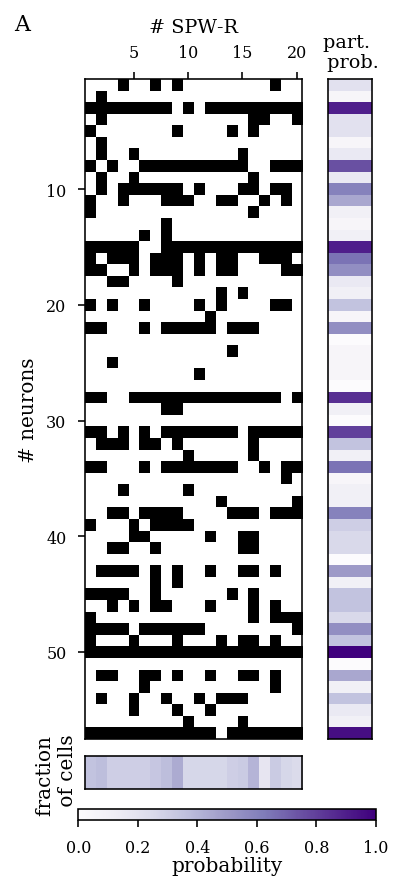

In [570]:
fig, axs = plt.subplots(2,2, figsize=set_size('thesis', fraction=.5, subplots=(3, 1)),
                        gridspec_kw={'height_ratios': [10,.5],'width_ratios': [5,1]})
fig.subplots_adjust(hspace = 0.05, wspace=0.2)
axs = axs.ravel()

axs[0].imshow(recruit_frac.T,cmap='binary',extent=[.5,recruit_frac.shape[0]+.5,recruit_frac.shape[1]+.5,.5],aspect='auto')

axs[1].imshow(rectuit_column[:,np.newaxis],extent=[0,1,0,recruit_frac.shape[1]],aspect='auto',cmap='Purples',vmin=0,vmax=1)

axs[2].imshow(rectuit_row[np.newaxis,:],extent=[0,recruit_frac.shape[0],0,1],aspect='auto',cmap='Purples',vmin=0,vmax=1)

axs[0].xaxis.tick_top()

axs[1].axes.get_xaxis().set_ticks([])
axs[2].axes.get_xaxis().set_ticks([])
axs[1].axes.get_yaxis().set_ticks([])
axs[2].axes.get_yaxis().set_ticks([])
axs[3].axis('off')


axs[0].set_title('# SPW-R')
axs[0].set_ylabel('# neurons')


axs[1].set_title('part. \n prob.')
axs[2].set_ylabel('fraction \n of cells')

import matplotlib as mpl

norm = mpl.colors.Normalize(vmin=0,vmax=1)
sm = plt.cm.ScalarMappable(cmap='Purples', norm=norm)
sm.set_array([])
plt.subplots_adjust(bottom=0.1, right=0.8, top=1)
cax = plt.axes([.11, 0.06, 0.7, 0.015])
cbar = plt.colorbar(sm,cax=cax,orientation="horizontal")
cbar.set_label('probability', labelpad=0)
# cbar.outline.set_visible(False)

axs[0].text(-0.25, 1.1, 'A', transform=axs[0].transAxes,fontsize=11, fontweight='normal', va='top', ha='right')

plt.savefig(os.path.join(fig_save_path,'participation_example.svg'),dpi=300,bbox_inches='tight')

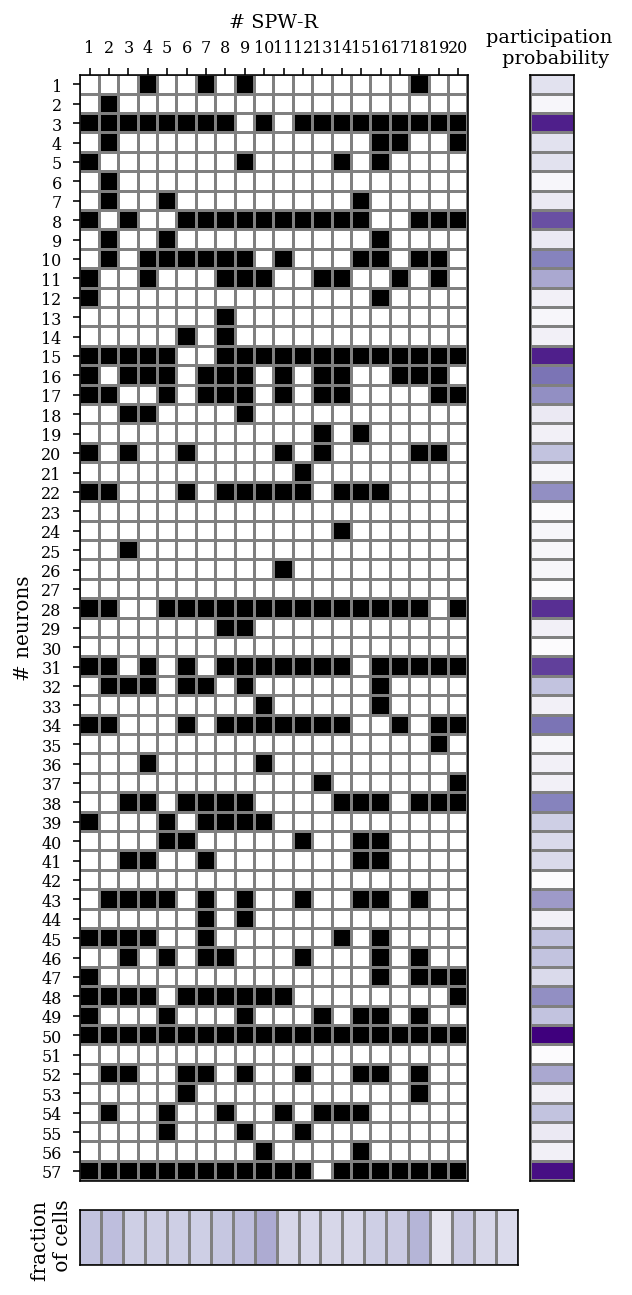

In [418]:
# fig, axs = plt.subplots(2,2, figsize=set_size('thesis', fraction=.75, subplots=(4, 1)),
#                         gridspec_kw={'height_ratios': [10,.5],'width_ratios': [5,.5]})

# fig.subplots_adjust(hspace = 0.05, wspace=0.05)
# axs = axs.ravel()

# x = np.arange(0, recruit_frac.T.shape[1]+1, 1)
# y = np.arange(0, recruit_frac.T.shape[0]+1, 1)
# X, Y = np.meshgrid(x, y)

# axs[0].pcolormesh(X,Y,recruit_frac.T, edgecolors='grey', linewidth=1,cmap='binary')
# axs[0].set_aspect('equal')
# axs[0].invert_yaxis()

# # put the major ticks at the middle of each cell
# axs[0].set_xticks(np.arange(recruit_frac.shape[0]) + 0.5, minor=False)
# axs[0].set_yticks(np.arange(recruit_frac.shape[1]) + 0.5, minor=False)

# axs[0].xaxis.tick_top()

# column_labels = np.arange(1,recruit_frac.shape[0]+1)
# row_labels = np.arange(1,recruit_frac.shape[1]+1)

# axs[0].set_xticklabels(column_labels, minor=False)
# axs[0].set_yticklabels(row_labels, minor=False)


# # axs[1].axis('off')
# # axs[2].axis('off')
# axs[3].axis('off')


# axs[1].pcolormesh(rectuit_column[:,np.newaxis], edgecolors='grey', linewidth=1,cmap='Purples',vmin=0,vmax=1)
# axs[1].invert_yaxis()


# axs[2].pcolormesh(rectuit_row[:,np.newaxis].T, edgecolors='grey', linewidth=1,cmap='Purples',vmin=0,vmax=1)
# # axs[2].plot(rectuit_row,'.k')
# # axs[2].set_ylim(0,1)
# # axs[2].invert_yaxis()

# # axs[2].set_xticks(np.arange(recruit_frac.shape[0]) + 0.5, minor=False)
# # axs[2].set_xticklabels(column_labels, minor=False)
# # axs[2].set_yticklabels(row_labels, minor=False)

# axs[0].set_title('# SPW-R')
# axs[0].set_ylabel('# neurons')


# axs[1].set_title('participation \n probability')
# axs[2].set_ylabel('fraction \n of cells')

# axs[1].axes.get_xaxis().set_ticks([])
# axs[2].axes.get_xaxis().set_ticks([])
# axs[1].axes.get_yaxis().set_ticks([])
# axs[2].axes.get_yaxis().set_ticks([])

# for ax in axs:
#     ax.set_anchor('W')
    
# # fig.tight_layout()

# # plt.show()

# # plt.savefig(os.path.join(fig_save_path,'example.svg'),dpi=300,bbox_inches='tight')